# Part 2: Custom Tasks, Task Families, and Performance Improvements

In this part, we will look at how to define custom tasks and datasets. We will also consider _families_ of tasks, which are common specifications of meta-learning problems. Finally, we will look at how to efficiently parallelize over tasks during training.

## Prerequisites

This document assumes knowledge of JAX which is covered in depth at the [JAX Docs](https://jax.readthedocs.io/en/latest/index.html).
In particular, we would recomend making your way through [JAX tutorial 101](https://jax.readthedocs.io/en/latest/jax-101/index.html). We also recommend that you have worked your way through Part 1.

In [2]:
#!pip install git+https://github.com/google/learned_optimization.git
!git clone https://github.com/google/learned_optimization.git
%cd learned_optimization


Cloning into 'learned_optimization'...
remote: Enumerating objects: 2545, done.
remote: Counting objects: 100% (666/666), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 2545 (delta 555), reused 520 (delta 518), pack-reused 1879 (from 2)
Receiving objects: 100% (2545/2545), 6.45 MiB | 17.56 MiB/s, done.
Resolving deltas: 100% (1857/1857), done.
/content/learned_optimization


In [3]:
!pip install dm-haiku

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.9/373.9 kB 24.9 MB/s eta 0:00:00


In [4]:
import numpy as np
import jax.numpy as jnp
import jax
from matplotlib import pylab as plt

from learned_optimization.outer_trainers import full_es
from learned_optimization.outer_trainers import truncated_pes
from learned_optimization.outer_trainers import gradient_learner
from learned_optimization.outer_trainers import truncation_schedule

from learned_optimization.tasks import quadratics
from learned_optimization.tasks.fixed import image_mlp
from learned_optimization.tasks import base as tasks_base
from learned_optimization.tasks.datasets import base as datasets_base

from learned_optimization.learned_optimizers import base as lopt_base
from learned_optimization.learned_optimizers import mlp_lopt
from learned_optimization.optimizers import base as opt_base

from learned_optimization import optimizers
from learned_optimization import eval_training

import haiku as hk
import tqdm
!pip install oryx


ERROR:absl:Oryx not found! This library will still work but no summarywill be logged.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.8/206.8 kB 14.1 MB/s eta 0:00:00


## Defining a custom Dataset

The dataset's in this library consists of iterators which yield batches of the corresponding data. For the provided tasks, these dataset have 4 splits of data rather than the traditional 3. We have "train" which is data used by the task to train a model, "inner_valid" which contains validation data for use when inner training (training an instance of a task). This could be use for, say, picking hparams. "outer_valid" which is used to meta-train with -- this is unseen in inner training and thus serves as a basis to train learned optimizers against. "test" which can be used to test the learned optimizer with.

To make a dataset, simply write 4 iterators with these splits.

For performance reasons, creating these iterators cannot be slow.
The existing dataset's make extensive use of caching to share iterators across tasks which use the same data iterators.
To account for this reuse, it is expected that these iterators are always randomly sampling data and have a large shuffle buffer so as to not run into any sampling issues.

In [5]:
import numpy as np


def data_iterator():
  bs = 3
  while True:
    batch = {"data": np.zeros([bs, 5])}
    yield batch


@datasets_base.dataset_lru_cache
def get_datasets():
  return datasets_base.Datasets(
      train=data_iterator(),
      inner_valid=data_iterator(),
      outer_valid=data_iterator(),
      test=data_iterator())


ds = get_datasets()
next(ds.train)

{'data': array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])}

## Defining a custom `Task`

To define a custom class, one simply needs to write a base class of `Task`. Let's look at a simple task consisting of a quadratic task with noisy targets.

In [6]:
# First we construct data iterators.
def noise_datasets():

  def _fn():
    while True:
      yield np.random.normal(size=[4, 2]).astype(dtype=np.float32)

  return datasets_base.Datasets(
      train=_fn(), inner_valid=_fn(), outer_valid=_fn(), test=_fn())


class MyTask(tasks_base.Task):
  datasets = noise_datasets()

  def loss(self, params, rng, data):
    return jnp.sum(jnp.square(params - data))

  def init(self, key):
    return jax.random.normal(key, shape=(4, 2))


task = MyTask()
key = jax.random.PRNGKey(0)
key1, key = jax.random.split(key)
params = task.init(key)

task.loss(params, key1, next(task.datasets.train))

Array(20.124702, dtype=float32)

## Meta-training on multiple tasks: `TaskFamily`

What we have shown previously was meta-training on a single task instance.
While sometimes this is sufficient for a given situation, in many situations we seek to meta-train a meta-learning algorithm such as a learned optimizer on a mixture of different tasks.

One path to do this is to simply run more than one meta-gradient computation, each with different tasks, average the gradients, and perform one meta-update.
This works great when the tasks are quite different -- e.g. meta-gradients when training a convnet vs a MLP.
A big negative to this is that these meta-gradient calculations are happening sequentially, and thus making poor use of hardware accelerators like GPU or TPU.

As a solution to this problem, we have an abstraction of a `TaskFamily` to enable better use of hardware. A `TaskFamily` represents a distribution over a set of tasks and specifies particular samples from this distribution as a pytree of jax types.

The function to sample these configurations is called `sample`, and the function to get a task from the sampled config is `task_fn`. `TaskFamily` also optionally contain datasets which are shared for all the `Task` it creates.

As a simple example, let's consider a family of quadratics parameterized by meansquared error to some point which itself is sampled.

In [15]:
PRNGKey = jnp.ndarray
TaskParams = jnp.ndarray


class FixedDimQuadraticFamily(tasks_base.TaskFamily):
  """A simple TaskFamily with a fixed dimensionality but sampled target."""

  def __init__(self, dim: int):
    super().__init__()
    self._dim = dim
    params = jax.random.normal(subkey, shape=(task._dim,))

    self.datasets = None

  def sample(self, key: PRNGKey) -> TaskParams:
    # Sample the target for the quadratic task.
    return jax.random.normal(key, shape=(self._dim,))

  def task_fn(self, task_params: TaskParams) -> tasks_base.Task:
    dim = self._dim

    class _Task(tasks_base.Task):

      def loss(self, params, rng, _):
        # Compute MSE to the target task.
        return jnp.sum(jnp.square(task_params - params))

      def init(self, key):
        return jax.random.normal(key, shape=(dim,))

    return _Task()

class ZDT1TaskFamily(tasks_base.TaskFamily):
    def __init__(self, dim=30):
        super().__init__()
        self._dim = dim

    def sample(self, key):
        return None  # pas de paramètre particulier

    def task_fn(self, _):
        return ZDT1Task(self._dim)
class ZDT1Task(tasks_base.Task):
    def __init__(self, dim):
        self._dim = dim

    def init(self, key):
        return jax.random.uniform(key, shape=(self._dim,), minval=0.0, maxval=1.0)

    def loss(self, params, key, data=None):
        # On calcule les deux objectifs f1 et f2
        f1 = params[0]
        g = 1.0 + 9.0 * jnp.sum(params[1:]) / (self._dim - 1)
        h = 1.0 - jnp.sqrt(f1 / g)
        f2 = g * h

        # SCALARISATION LINEAIRE : on choisit arbitrairement w1=0.5, w2=0.5
        scalarized_loss = 0.5 * f1 + 0.5 * f2

        return scalarized_loss


*With* this task family defined, we can create instances by sampling a configuration and creating a task. This task acts like any other task in that it has an `init` and a `loss` function.

In [8]:
task_family = FixedDimQuadraticFamily(10)
key = jax.random.PRNGKey(0)
task_cfg = task_family.sample(key)
task = task_family.task_fn(task_cfg)

key1, key = jax.random.split(key)
params = task.init(key)
batch = None
task.loss(params, key, batch)

Array(48.277, dtype=float32)

To achive speedups, we can now leverage `jax.vmap` to train *multiple* task instances in parallel! Depending on the task, this can be considerably faster than serially executing them.

In [9]:
def train_task(cfg, key):
  task = task_family.task_fn(cfg)
  key1, key = jax.random.split(key)
  params = task.init(key1)
  opt = opt_base.Adam()

  opt_state = opt.init(params)

  for i in range(4):
    params = opt.get_params(opt_state)
    loss, grad = jax.value_and_grad(task.loss)(params, key, None)
    opt_state = opt.update(opt_state, grad, loss=loss)
  loss = task.loss(params, key, None)
  return loss


task_cfg = task_family.sample(key)
print("single loss", train_task(task_cfg, key))

keys = jax.random.split(key, 32)
task_cfgs = jax.vmap(task_family.sample)(keys)
losses = jax.vmap(train_task)(task_cfgs, keys)
print("multiple losses", losses)

single loss 18.214954
multiple losses [ 2.8170602 10.142114  14.761778  23.247692  16.302574  21.237566
 21.430893  15.900445  20.618113   8.978045  22.02934   11.658101
 27.078705  10.773317  21.98583   20.727951   9.322435  75.87089
 20.872551  14.829137  16.828785   7.5891085 46.468025  14.948075
 17.866491  20.287266   2.4742956 14.716241  18.888268  15.309628
 12.353992  15.238528 ]


Because of this ability to apply vmap over task families, this is the main building block for a number of the high level libraries in this package. Single tasks can always be converted to a task family with:

In [10]:
single_task = image_mlp.ImageMLP_FashionMnist8_Relu32()
task_family = tasks_base.single_task_to_family(single_task)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.HGKEV4_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.HGKEV4_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


This wrapper task family has no configuable value and always returns the base task.

In [11]:
cfg = task_family.sample(key)
print("config only contains a dummy value:", cfg)
task = task_family.task_fn(cfg)
# Tasks are the same
assert task == single_task

config only contains a dummy value: 0


## Limitations of `TaskFamily`
Task families are designed for, and only work for variation that results in a static computation graph. This is required for `jax.vmap` to work.

This means things like naively changing hidden sizes, or number of layers, activation functions is off the table.

In some cases, one can leverage other jax control flow such as `jax.lax.cond` to select between implementations. For example, one could make a `TaskFamily` that used one of 2 activation functions. While this works, the resulting vectorized computation could be slow and thus profiling is required to determine if this is a good idea or not.

In this code base, we use `TaskFamily` to mainly parameterize over different kinds of initializations.

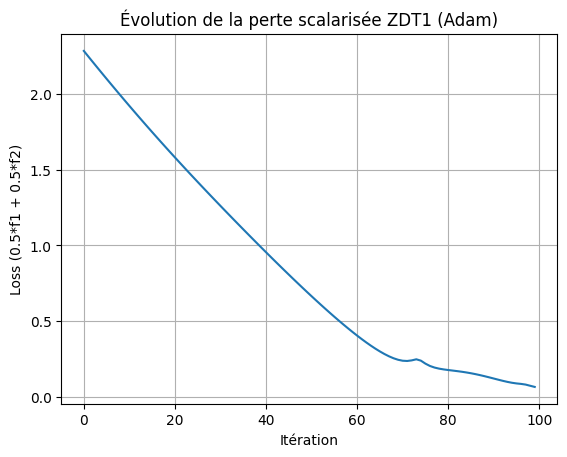

In [12]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    from optax import adam
    import optax # Import optax here

    # 1. Créer ta tâche
    task_family = ZDT1TaskFamily(dim=30)
    task = task_family.task_fn(None)

    # 2. Initialiser les paramètres de la tâche
    key = jax.random.PRNGKey(0)
    params = task.init(key)

    # 3. Initialiser l'optimiseur Adam
    opt = adam(learning_rate=0.01)
    opt_state = opt.init(params)

    # 4. Lancer une boucle d’optimisation
    losses = []
    for step in range(100):
        loss_value, grads = jax.value_and_grad(task.loss)(params, key)
        updates, opt_state = opt.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

        losses.append(loss_value)

    # 5. Afficher l’évolution de la perte
    plt.plot(losses)
    plt.title("Évolution de la perte scalarisée ZDT1 (Adam)")
    plt.xlabel("Itération")
    plt.ylabel("Loss (0.5*f1 + 0.5*f2)")
    plt.grid()
    plt.show()


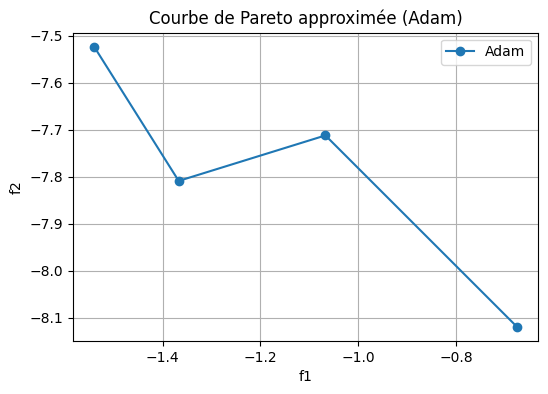

In [14]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    import optax
    import numpy as np

    key = jax.random.PRNGKey(0)
    task_family = ZDT1TaskFamily(dim=30)

    weights_list = [(w, 1 - w) for w in np.linspace(0.1, 0.9, 9)]

    f1_list = []
    f2_list = []

    for i, weights in enumerate(weights_list):
        subkey = jax.random.fold_in(key, i)
        task = task_family.task_fn(None)
        params = task.init(subkey)

        def scalarized_loss_fn(p):
          p = jax.nn.sigmoid(p)  # Contraint les paramètres dans [0,1]
          f1 = p[0]
          g = 1.0 + 9.0 * jnp.sum(p[1:]) / (task._dim - 1)
          h = 1.0 - jnp.sqrt(f1 / g)
          f2 = g * h
          return weights[0] * f1 + weights[1] * f2


        opt = optax.adam(learning_rate=0.01)
        opt_state = opt.init(params)

        for step in range(200):
            loss_val, grads = jax.value_and_grad(scalarized_loss_fn)(params)
            updates, opt_state = opt.update(grads, opt_state)
            params = optax.apply_updates(params, updates)


        params_final = jax.nn.sigmoid(params)  # Rendu dans [0,1]

        # Calcul final des vrais objectifs f1 et f2
        f1 = params[0]
        g = 1 + 9 * jnp.sum(params[1:]) / (task._dim - 1)
        h = 1 - jnp.sqrt(f1 / g)
        f2 = g * h

        f1_list.append(float(f1))
        f2_list.append(float(f2))

    # ➕ Affichage du front de Pareto obtenu avec Adam
    plt.figure(figsize=(6, 4))
    plt.plot(f1_list, f2_list, 'o-', label="Adam")
    plt.xlabel("f1")
    plt.ylabel("f2")
    plt.title("Courbe de Pareto approximée (Adam)")
    plt.grid()
    plt.legend()
    plt.show()
